In [1]:
from gc import collect
from os.path import join

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy
import scienceplots  # noqa
from cache_to_disk import cache_to_disk, delete_disk_caches_for_function
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import kendalltau
from tqdm import tqdm, trange

import csiborgtools
import plt_utils


import plot_match
%matplotlib widget
%load_ext autoreload
%autoreload 2

paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)
ext = "png"
to_save = True

## $M_{\rm tot}$ - all pair overlaps

Stacking the results of a single reference simulation with the other boxes.

Saving to `../plots/mass_vs_pair_overlap_quijote_0.png`.


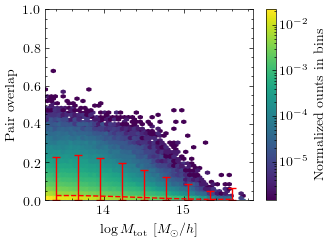

In [11]:
nsim0 = 0
simname = "quijote"
mass_kind = "group_mass"
min_logmass = 13.25
smoothed = True
nbins=10

################################################################################

@cache_to_disk(21)
def get_mtot_vs_all_pairoverlap(nsim0, simname, mass_kind, min_logmass, smoothed, nbins):
    nsimxs = csiborgtools.read.get_cross_sims(simname, nsim0, paths, min_logmass, smoothed=smoothed)[:2]
    cat0 = plot_match.open_cat(nsim0, simname)
    catxs = plot_match.open_cats(nsimxs, simname)

    reader = csiborgtools.read.NPairsOverlap(cat0, catxs, paths, min_logmass)

    x = [None] * len(catxs)
    y = [None] * len(catxs)
    for i in trange(len(catxs), desc="Stacking catalogues"):
        x[i] = numpy.log10(numpy.concatenate(reader[i].copy_per_match(mass_kind)))
        y[i] = numpy.concatenate(reader[i].overlap(smoothed))

    x = numpy.concatenate(x)
    y = numpy.concatenate(y)

    xbins = numpy.linspace(min(x), max(x), nbins)

    return x, y, xbins

################################################################################

# delete_disk_caches_for_function("get_mtot_vs_all_pairoverlap")
x, y, xbins = get_mtot_vs_all_pairoverlap(nsim0, simname, mass_kind, min_logmass, smoothed, nbins)

plt.close("all")
with plt.style.context(plt_utils.mplstyle):
    plt.figure()
    hb = plt.hexbin(x, y, mincnt=1, gridsize=50, bins="log")
    plt_utils.normalize_hexbin(hb)

    y_median, yerr = plt_utils.compute_error_bars(x, y, xbins, sigma=2)
    plt.errorbar(0.5 * (xbins[1:] + xbins[:-1]), y_median, yerr=yerr, color='red', ls='dashed', capsize=3)

    plt.colorbar(hb, label="Normalized ounts in bins")
    plt.xlabel(r"$\log M_{\rm tot} ~ [M_\odot / h]$")
    plt.ylabel("Pair overlap")
    plt.xlim(numpy.min(x))
    plt.ylim(0., 1.)

    plt.tight_layout()
    if to_save:
        fout = join(plt_utils.fout, f"mass_vs_pair_overlap_{simname}_{nsim0}.{ext}")
        print(f"Saving to `{fout}`.")
        plt.savefig(fout, dpi=plt_utils.dpi, bbox_inches="tight")
    plt.show()

## $M_{\rm tot}$ vs maximum pair overlap 

Saving to `../plots/mass_vs_max_pair_overlap0.png`.


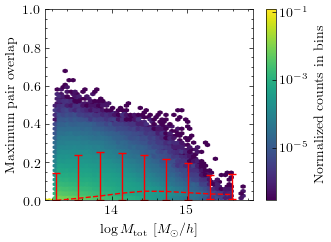

In [12]:
nsim0 = 0
simname = "quijote"
mass_kind = "group_mass"
smoothed = True
min_logmass = 13.25
nbins = 10

################################################################################

@cache_to_disk(21)
def data_mtot_vs_maxpairoverlap(nsim0, simname, mass_kind, min_logmass, smoothed, nbins):
    nsimxs = csiborgtools.read.get_cross_sims(simname, nsim0, paths, min_logmass, smoothed=smoothed)
    cat0 = plot_match.open_cat(nsim0, simname)
    catxs = plot_match.open_cats(nsimxs, simname)

    def get_max(y_):
        if len(y_) == 0:
            return 0
        return numpy.max(y_)

    reader = csiborgtools.read.NPairsOverlap(cat0, catxs, paths, min_logmass)

    x = [None] * len(catxs)
    y = [None] * len(catxs)
    for i in trange(len(catxs), desc="Stacking catalogues"):
        x[i] = numpy.log10(cat0[mass_kind])
        y[i] = numpy.array([get_max(y_) for y_ in reader[i].overlap(smoothed)])

    x = numpy.concatenate(x)
    y = numpy.concatenate(y)

    xbins = numpy.linspace(min(x), max(x), nbins)

    return x, y, xbins

################################################################################

# delete_disk_caches_for_function("data_mtot_vs_maxpairoverlap")
x, y, xbins = data_mtot_vs_maxpairoverlap(nsim0, simname, mass_kind, min_logmass, smoothed, nbins)

plt.close("all")
with plt.style.context(plt_utils.mplstyle):
    plt.figure()

    hb = plt.hexbin(x, y, mincnt=1, gridsize=50, bins="log")
    plt_utils.normalize_hexbin(hb)

    y_median, yerr = plt_utils.compute_error_bars(x, y, xbins, sigma=2)
    plt.errorbar(0.5 * (xbins[1:] + xbins[:-1]), y_median, yerr=yerr, color='red', ls='dashed', capsize=3)

    plt.colorbar(label="Normalized counts in bins")
    plt.xlabel(r"$\log M_{\rm tot} ~ [M_\odot / h]$")
    plt.ylabel("Maximum pair overlap")
    plt.ylim(0., 1.)
    plt.xlim(numpy.min(x))

    plt.tight_layout()
    if to_save:
        fout = join(plt_utils.fout, f"mass_vs_max_pair_overlap{nsim0}.{ext}")
        print(f"Saving to `{fout}`.")
        plt.savefig(fout, dpi=plt_utils.dpi, bbox_inches="tight")
    plt.show()

## $M_{\rm tot}$ vs summed overlap

In [25]:
simname = "quijote"
nsim0 = 0
min_logmass = 13.25
nbins = 10
smoothed = True

# delete_disk_caches_for_function("get_overlap_summary")
x = plot_match.get_overlap_summary(nsim0, simname, min_logmass, smoothed)


mass0 = numpy.log10(x["mass0"])

mean_overlap = numpy.nanmean(x["summed_overlap"], axis=1)
std_overlap = numpy.nanstd(x["summed_overlap"], axis=1)
mean_prob_nomatch = numpy.nanmean(x["prob_nomatch"], axis=1)

xbins = numpy.linspace(numpy.nanmin(mass0), numpy.nanmax(mass0), nbins)

/mnt/zfsusers/rstiskalek/csiborgtools/csiborgtools/read/paths.py:317: UserWarning: Taking only the snapshots that also have a FoF catalogue!
  warn("Taking only the snapshots that also have a FoF catalogue!")
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
Calculating probability of no match: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Saving to `../plots/overlap_stat_quijote_0.png`.


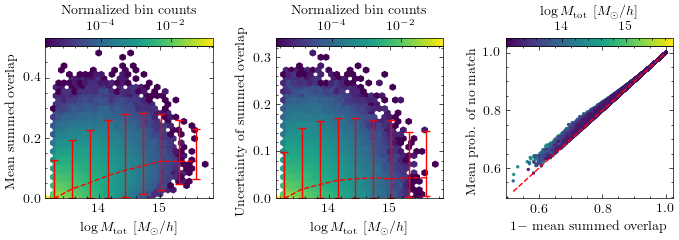

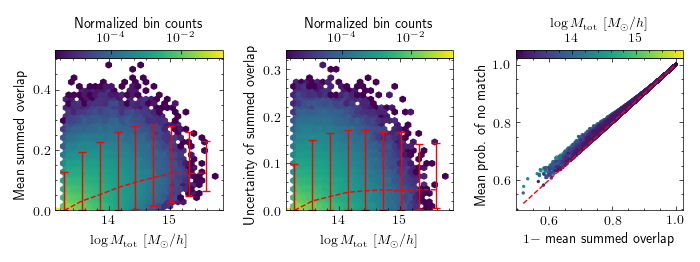

In [29]:
with plt.style.context(plt_utils.mplstyle):
    fig, axs = plt.subplots(ncols=3, figsize=(3.5 * 2, 2.625))

    im1 = axs[0].hexbin(mass0, mean_overlap, mincnt=1, bins="log", gridsize=30)
    plt_utils.normalize_hexbin(im1)

    y_median, yerr = plt_utils.compute_error_bars(mass0, mean_overlap, xbins, sigma=2)
    axs[0].errorbar(0.5 * (xbins[1:] + xbins[:-1]), y_median, yerr=yerr, color='red', ls='dashed', capsize=3)

    im2 = axs[1].hexbin(mass0, std_overlap, mincnt=1, bins="log", gridsize=30)
    plt_utils.normalize_hexbin(im2)

    y_median, yerr = plt_utils.compute_error_bars(mass0, std_overlap, xbins, sigma=2)
    axs[1].errorbar(0.5 * (xbins[1:] + xbins[:-1]), y_median, yerr=yerr, color='red', ls='dashed', capsize=3)

    im3 = axs[2].scatter(1 - mean_overlap, mean_prob_nomatch, c=mass0, s=2, rasterized=True)

    t = numpy.linspace(numpy.nanmin(1 - mean_overlap), 1, 100)
    axs[2].plot(t, t, color="red", linestyle="--")

    axs[0].set_ylim(0.)
    axs[1].set_ylim(0.)
    axs[0].set_xlim(numpy.min(mass0))
    axs[1].set_xlim(numpy.min(mass0))
    axs[0].set_xlabel(r"$\log M_{\rm tot} ~ [M_\odot / h]$")
    axs[0].set_ylabel("Mean summed overlap")
    axs[1].set_xlabel(r"$\log M_{\rm tot} ~ [M_\odot / h]$")
    axs[1].set_ylabel("Uncertainty of summed overlap")
    axs[2].set_xlabel(r"$1 - $ mean summed overlap")
    axs[2].set_ylabel("Mean prob. of no match")

    label = ["Normalized bin counts", "Normalized bin counts", r"$\log M_{\rm tot} ~ [M_\odot / h]$"]
    ims = [im1, im2, im3]
    for i in range(3):
        axins = axs[i].inset_axes([0.0, 1.0, 1.0, 0.05])
        fig.colorbar(ims[i], cax=axins, orientation="horizontal", label=label[i])
        axins.xaxis.tick_top()
        axins.xaxis.set_tick_params(labeltop=True)
        axins.xaxis.set_label_position("top")

    fig.tight_layout()
    if to_save:
        fout = join(plt_utils.fout, f"overlap_stat_{simname}_{nsim0}.{ext}")
        print(f"Saving to `{fout}`.")
        fig.savefig(fout, dpi=plt_utils.dpi, bbox_inches="tight")
    fig.show()

## $M_{\rm tot}$ vs mean maximum overlap

Saving to `../plots/maxpairoverlap_0.png`.


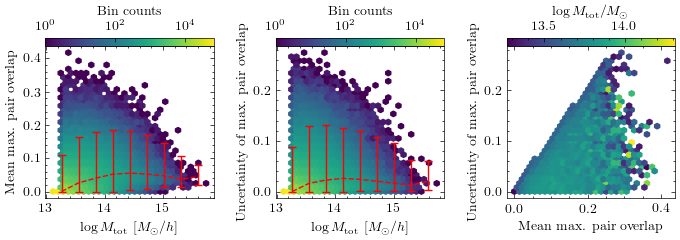

In [35]:
simname = "quijote"
nsim0 = 0
min_logmass = 13.25
nbins = 10
smoothed = True

# delete_disk_caches_for_function("get_overlap_summary")
x = plot_match.get_overlap_summary(nsim0, simname, min_logmass, smoothed)


mass0 = numpy.log10(x["mass0"])
max_overlap = x["max_overlap"]

xbins = numpy.linspace(numpy.nanmin(mass0), numpy.nanmax(mass0), nbins)

mean_max_overlap = numpy.nanmean(max_overlap, axis=1)
std_max_overlap = numpy.nanstd(max_overlap, axis=1)


with plt.style.context(plt_utils.mplstyle):
    fig, axs = plt.subplots(ncols=3, figsize=(3.5 * 2, 2.625))
    im1 = axs[0].hexbin(mass0, mean_max_overlap, gridsize=30, mincnt=1, bins="log")
    y_median, yerr = plt_utils.compute_error_bars(mass0, mean_max_overlap, xbins, sigma=2)
    axs[0].errorbar(0.5 * (xbins[1:] + xbins[:-1]), y_median, yerr=yerr, color='red', ls='dashed', capsize=3)

    im2 = axs[1].hexbin(mass0, std_max_overlap, gridsize=30, mincnt=1, bins="log")
    y_median, yerr = plt_utils.compute_error_bars(mass0, std_max_overlap, xbins, sigma=2)
    axs[1].errorbar(0.5 * (xbins[1:] + xbins[:-1]), y_median, yerr=yerr, color='red', ls='dashed', capsize=3)

    im3 = axs[2].hexbin(numpy.nanmean(max_overlap, axis=1), numpy.nanstd(max_overlap, axis=1), gridsize=30, C=mass0, reduce_C_function=numpy.nanmean)

    axs[0].set_xlabel(r"$\log M_{\rm tot} ~ [M_\odot / h]$")
    axs[0].set_ylabel(r"Mean max. pair overlap")
    axs[1].set_xlabel(r"$\log M_{\rm tot} ~ [M_\odot / h]$")
    axs[1].set_ylabel(r"Uncertainty of max. pair overlap")
    axs[2].set_xlabel(r"Mean max. pair overlap")
    axs[2].set_ylabel(r"Uncertainty of max. pair overlap")

    label = ["Bin counts", "Bin counts", r"$\log M_{\rm tot} / M_\odot$"]
    ims = [im1, im2, im3]
    for i in range(3):
        axins = axs[i].inset_axes([0.0, 1.0, 1.0, 0.05])
        fig.colorbar(ims[i], cax=axins, orientation="horizontal",
                     label=label[i])
        axins.xaxis.tick_top()
        axins.xaxis.set_tick_params(labeltop=True)
        axins.xaxis.set_label_position("top")

    fig.tight_layout()
    if to_save:
        fout = join(plt_utils.fout, f"maxpairoverlap_{nsim0}.{ext}")
        print(f"Saving to `{fout}`.")
        fig.savefig(fout, dpi=plt_utils.dpi, bbox_inches="tight")
    plt.show()

## $M_{\rm tot}$ vs separation

Saving to `../plots/mass_vs_sep_0_1_std.png`.


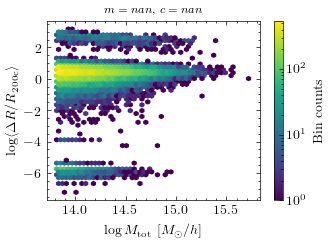

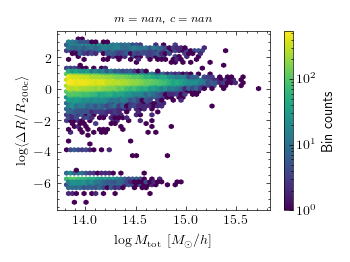

In [42]:
nsim0 = 0
nsimx = 1
simname = "quijote"
mass_kind = "group_mass"
min_logmass = 13.25
nbins = 10
smoothed = True
plot_std = False

################################################################################

@cache_to_disk(21)
def get_mass_vs_separation(nsim0, nsimx, simname, mass_kind, min_logmass, nbins, smoothed):
    paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)
    nsimxs = csiborgtools.read.get_cross_sims(simname, nsim0, paths, min_logmass, smoothed=smoothed)[:2]

    cat0 = plot_match.open_cat(nsim0, simname)
    catx = plot_match.open_cat(nsimx, simname)

    reader = csiborgtools.read.PairOverlap(cat0, catx, paths, min_logmass)

    mass = numpy.log10(reader.cat0(mass_kind))
    dist = reader.dist(in_initial=False, norm_kind="r200c")
    overlap = reader.overlap(smoothed)
    dist = csiborgtools.read.weighted_stats(dist, overlap, min_weight=0)

    mask = numpy.isfinite(dist[:, 0])
    mass = mass[mask]
    dist = dist[mask, :]
    dist = numpy.log10(dist)

    return mass, dist

################################################################################

# delete_disk_caches_for_function("get_mass_vs_separation")
mass, dist = get_mass_vs_separation(nsim0, nsimx, simname, mass_kind, min_logmass, nbins, smoothed)

if not plot_std:
    p = numpy.polyfit(mass, dist[:, 0], 1)
else:
    p = numpy.polyfit(mass, dist[:, 1], 1)

xrange = numpy.linspace(numpy.min(mass), numpy.max(mass), 1000)
txt = r"$m = {}$, $c = {}$".format(*plt_utils.latex_float(*p, n=3))

plt.close("all")
with plt.style.context(plt_utils.mplstyle):
    fig, ax = plt.subplots()
    ax.set_title(txt, fontsize="small")

    if not plot_std:
        cx = ax.hexbin(mass, dist[:, 0], mincnt=1, bins="log", gridsize=50)
        ax.set_ylabel(r"$\log \langle \Delta R / R_{\rm 200c}\rangle$")
    else:
        cx = ax.hexbin(mass, dist[:, 1], mincnt=1, bins="log", gridsize=50)
        ax.set_ylabel(
            r"$\delta \log \langle \Delta R / R_{\rm 200c}\rangle$")

    ax.plot(xrange, numpy.polyval(p, xrange), color="red",
            linestyle="--")
    fig.colorbar(cx, label="Bin counts")
    ax.set_xlabel(r"$\log M_{\rm tot} ~ [M_\odot / h]$")
    ax.set_ylabel(r"$\log \langle \Delta R / R_{\rm 200c}\rangle$")

    fig.tight_layout()
    if to_save:
        fout = join(plt_utils.fout,
                    f"mass_vs_sep_{nsim0}_{nsimx}.{ext}")
        if plot_std:
            fout = fout.replace(f".{ext}", f"_std.{ext}")
        print(f"Saving to `{fout}`.")
        fig.savefig(fout, dpi=plt_utils.dpi, bbox_inches="tight")
    fig.show()

## $M_{\rm tot}$ vs maximum overlap mass

True to expectation corr:  SignificanceResult(statistic=0.10355960805849727, pvalue=3.885645199185645e-87)
Saving to `../plots/max_totpartmass_quijote_0_13.25.png`.


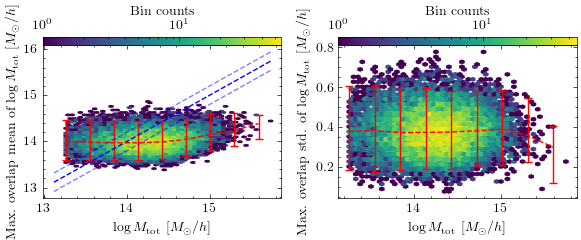

In [62]:
nsim0 = 0
simname = "quijote"
mass_kind = "group_mass"
min_log_mass = 13.25
smoothed = True
nbins = 10


# delete_disk_caches_for_function("get_property_maxoverlap")
x = plot_match.get_property_maxoverlap(nsim0, simname, min_logmass, mass_kind, smoothed)

mass0 = x["mass0"]
stat = x["prop_maxoverlap"]

mu = numpy.mean(stat, axis=1)
std = numpy.std(numpy.log10(stat), axis=1)
mu = numpy.log10(mu)

mass0 = numpy.log10(mass0)
xbins = numpy.linspace(*numpy.percentile(mass0, [0, 100]), nbins)

with plt.style.context(plt_utils.mplstyle):
    fig, axs = plt.subplots(ncols=2, figsize=(3.5 * 1.75, 2.625))

    m = numpy.isfinite(mass0) & numpy.isfinite(mu)

    im0 = axs[0].hexbin(mass0, mu, mincnt=1, bins="log", gridsize=50)
    y_median, yerr = plt_utils.compute_error_bars(mass0[m], mu[m], xbins, sigma=2)
    axs[0].errorbar(0.5 * (xbins[1:] + xbins[:-1]), y_median, yerr=yerr, color='red', ls='dashed', capsize=3)

    im1 = axs[1].hexbin(mass0, std, mincnt=1, bins="log", gridsize=50)
    y_median, yerr = plt_utils.compute_error_bars(mass0[m], std[m], xbins, sigma=2)
    axs[1].errorbar(0.5 * (xbins[1:] + xbins[:-1]), y_median, yerr=yerr, color='red', ls='dashed', capsize=3)

    print("True to expectation corr: ", kendalltau(mass0[m], mu[m]))

    t = numpy.linspace(*numpy.percentile(mass0, [0, 100]), 1000)
    axs[0].plot(t, t, color="blue", linestyle="--")
    axs[0].plot(t, t + 0.2, color="blue", linestyle="--", alpha=0.5)
    axs[0].plot(t, t - 0.2, color="blue", linestyle="--", alpha=0.5)

    axs[0].set_xlabel(r"$\log M_{\rm tot} ~ [M_\odot / h]$")
    axs[1].set_xlabel(r"$\log M_{\rm tot} ~ [M_\odot / h]$")
    axs[0].set_ylabel(
        r"Max. overlap mean of $\log M_{\rm tot} ~ [M_\odot / h]$")
    axs[1].set_ylabel(
        r"Max. overlap std. of $\log M_{\rm tot} ~ [M_\odot / h]$")

    ims = [im0, im1]
    for i in range(2):
        axins = axs[i].inset_axes([0.0, 1.0, 1.0, 0.05])
        fig.colorbar(ims[i], cax=axins, orientation="horizontal",
                     label="Bin counts")
        axins.xaxis.tick_top()
        axins.xaxis.set_tick_params(labeltop=True)
        axins.xaxis.set_label_position("top")

    fig.tight_layout()
    if to_save:
        fout = join(plt_utils.fout, f"max_totpartmass_{simname}_{nsim0}_{min_logmass}.{ext}")
        print(f"Saving to `{fout}`.")
        fig.savefig(fout, dpi=plt_utils.dpi, bbox_inches="tight")
    plt.show()

## $M_{\rm tot}$ vs expected mass

Saving to `../plots/mass_vs_expmass_0_quijote_1.png`.


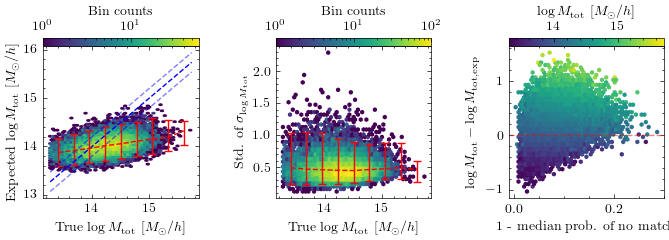

In [58]:
nsim0 = 0
simname = "quijote"
mass_kind = "group_mass"
min_log_mass = 13.25
smoothed = True
min_overlap = 0
max_prob_nomatch = 1
nbins = 10


# delete_disk_caches_for_function("get_expected_mass")
x = plot_match.get_expected_mass(nsim0, simname, min_overlap, min_log_mass, smoothed)

mass = x["mass0"]
mu = x["mu"]
std = x["std"]
prob_nomatch = x["prob_nomatch"]


std = std / mu / numpy.log(10)
mass = numpy.log10(mass)
mu = numpy.log10(mu)
prob_nomatch = numpy.nanmedian(prob_nomatch, axis=1)

mask = numpy.isfinite(mass) & numpy.isfinite(mu)
mask &= (prob_nomatch <= max_prob_nomatch)

xbins = numpy.linspace(*numpy.percentile(mass[mask], [0, 100]), nbins)

with plt.style.context(plt_utils.mplstyle):
    fig, axs = plt.subplots(ncols=3, figsize=(3.5 * 2, 2.625))

    im0 = axs[0].hexbin(mass[mask], mu[mask], mincnt=1, bins="log",
                        gridsize=50,)
    y_median, yerr = plt_utils.compute_error_bars(mass[mask], mu[mask], xbins, sigma=2)
    axs[0].errorbar(0.5 * (xbins[1:] + xbins[:-1]), y_median, yerr=yerr, color='red', ls='dashed', capsize=3)

    im1 = axs[1].hexbin(mass[mask], std[mask], mincnt=1, bins="log", gridsize=50)
    y_median, yerr = plt_utils.compute_error_bars(mass[mask], std[mask], xbins, sigma=2)
    axs[1].errorbar(0.5 * (xbins[1:] + xbins[:-1]), y_median, yerr=yerr, color='red', ls='dashed', capsize=3)

    im2 = axs[2].hexbin(1 - prob_nomatch[mask], mass[mask] - mu[mask],
                        gridsize=50, C=mass[mask],
                        reduce_C_function=numpy.nanmedian)

    axs[2].axhline(0, color="red", linestyle="--", alpha=0.5)
    axs[0].set_xlabel(r"True $\log M_{\rm tot} ~ [M_\odot / h]$")
    axs[0].set_ylabel(r"Expected $\log M_{\rm tot} ~ [M_\odot / h]$")
    axs[1].set_xlabel(r"True $\log M_{\rm tot} ~ [M_\odot / h]$")
    axs[1].set_ylabel(r"Std. of $\sigma_{\log M_{\rm tot}}$")
    axs[2].set_xlabel(r"1 - median prob. of no match")
    axs[2].set_ylabel(r"$\log M_{\rm tot} - \log M_{\rm tot, exp}$")

    t = numpy.linspace(*numpy.percentile(mass[mask], [0, 100]), 1000)
    axs[0].plot(t, t, color="blue", linestyle="--")
    axs[0].plot(t, t + 0.2, color="blue", linestyle="--", alpha=0.5)
    axs[0].plot(t, t - 0.2, color="blue", linestyle="--", alpha=0.5)

    ims = [im0, im1, im2]
    labels = ["Bin counts", "Bin counts", r"$\log M_{\rm tot} ~ [M_\odot / h]$"]
    for i in range(3):
        axins = axs[i].inset_axes([0.0, 1.0, 1.0, 0.05])
        fig.colorbar(ims[i], cax=axins, orientation="horizontal", label=labels[i])
        axins.xaxis.tick_top()
        axins.xaxis.set_tick_params(labeltop=True)
        axins.xaxis.set_label_position("top")

    fig.tight_layout()
    if to_save:
        fout = join(plt_utils.fout, f"mass_vs_expmass_{nsim0}_{simname}_{max_prob_nomatch}.{ext}")
        print(f"Saving to `{fout}`.")
        fig.savefig(fout, dpi=plt_utils.dpi, bbox_inches="tight")
    plt.show()